In [1]:
import sys
import os
import time
import codecs

sys.path.append("/Users/Bya/git/predictEPL/utils/")
sys.path.append("/Users/Bya/git/predictEPL/config/")

import paths
import tokenizer
import useful_methods as my_methods

In [51]:
%pylab inline
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import csv
from textblob import TextBlob
import pandas
import sklearn
import pickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

Populating the interactive namespace from numpy and matplotlib


### Step 1: Load Data, look around

In [3]:
os.chdir(paths.READ_PATH_REVIEW_SHORT)
reviews = my_methods.csv_dic_df("short_movie_reviews.csv")

In [4]:
reviews.groupby('sentiment').describe()

review
sentiment                                                          
0         count                                                5331
          unique                                               5331
          top     one of those based-on-truth stories that persu...
          freq                                                    1
1         count                                                5331
          unique                                               5331
          top     splendidly illustrates the ability of the huma...
          freq                                                    1

In [5]:
reviews['length'] = [len(text) for text in reviews['review']]
reviews.head()

,review,sentiment,length
0,has lost some of the dramatic conviction that ...,0,83
1,"it's good , hard-edged stuff , violent and a b...",1,118
2,this new time machine is hardly perfectÖ yet i...,1,122
3,terrific casting and solid execution give all ...,1,67
4,this is one of those rare docs that paints a g...,1,111


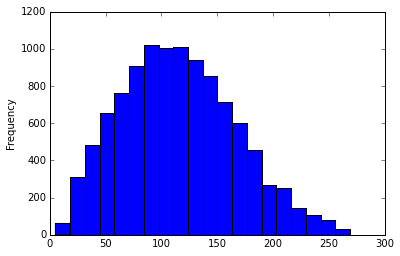

In [6]:
reviews.length.plot(bins=20, kind='hist')

In [7]:
reviews.length.describe()

count    10662.000000
mean       115.156256
std         51.199546
min          5.000000
25%         77.000000
50%        112.000000
75%        150.000000
max        269.000000
Name: length, dtype: float64

In [8]:
list(reviews.review[reviews.length > 268])

[" . . . spiced with humor ( 'i speak fluent flatula , ' advises denlopp after a rather , er , bubbly exchange with an alien deckhand ) and witty updatings ( silver's parrot has been replaced with morph , a cute alien creature who mimics everyone and everything around ) "]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1162879b0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1162c0780>], dtype=object)

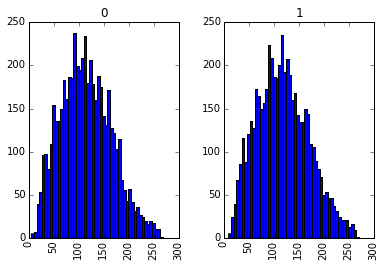

In [9]:
reviews.hist(column='length', by='sentiment', bins=50)

### Step 2: Data Preprocessing

In [ ]:
def split_into_tokens(review):
    return TextBlob(review).words

In [ ]:
reviews.review.head()

In [ ]:
reviews.review.head().apply(split_into_tokens)

In [ ]:
reviews.review.head().apply(tokenizer.TweetLemmaSoccer)

In [ ]:
TextBlob("Hello world, how is it going?").tags  # list of (word, POS) pairs

### Step 3: Data to Vectors

In [10]:
%time bow_transformer = CountVectorizer(analyzer=tokenizer.Lemma).fit(reviews['review'])
# unique words
print(len(bow_transformer.vocabulary_))

CPU times: user 8.68 s, sys: 71.5 ms, total: 8.75 s
Wall time: 8.86 s
21166


In [11]:
# Let's take one text message and get its bag-of-words counts as a vector,
# putting to use our new bow_transformer:

review4 = reviews['review'][3]
print(review4)

terrific casting and solid execution give all three stories life . 


In [ ]:
bow4 = bow_transformer.transform([review4])
print(bow4)
print(bow4.shape)

In [ ]:
print(bow_transformer.get_feature_names()[2765])
print(bow_transformer.get_feature_names()[15630])

In [12]:
# The bag-of-words counts for the entire Reviews corpus are a large,
# sparse matrix:

reviews_bow = bow_transformer.transform(reviews['review'])
print('sparse matrix shape:', reviews_bow.shape)
print('number of non-zeros:', reviews_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * reviews_bow.nnz / (reviews_bow.shape[0] * reviews_bow.shape[1])))

sparse matrix shape: (10662, 21166)
number of non-zeros: 113609
sparsity: 0.05%


In [13]:
# And finally, after the counting,
# the term weighting and normalization can be done with TF-IDF,
# using scikit-learn's TfidfTransformer:

tfidf_transformer = TfidfTransformer().fit(reviews_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

NameError: name 'bow4' is not defined

In [ ]:
# What is the IDF (inverse document frequency) of the
# word: "fun"? Of word: "go"?

print(tfidf_transformer.idf_[bow_transformer.vocabulary_['casting']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['story']])

In [14]:
# To transform the entire bag-of-words corpus into TF-IDF corpus at once:

reviews_tfidf = tfidf_transformer.transform(reviews_bow)
print(reviews_tfidf.shape)

(10662, 21166)


### Step 4: Training a model and, classifying sentiment

In [ ]:
%time sentiment_detector = MultinomialNB().fit(reviews_tfidf, reviews['sentiment'])

In [ ]:
# Let's try classifying our single random review:

print('predicted:', sentiment_detector.predict(tfidf4)[0])
print('expected:', reviews.sentiment[3])

In [ ]:
# How many messages do we classify correctly overall?

all_predictions = sentiment_detector.predict(reviews_tfidf)
print(all_predictions)

In [ ]:
print('accuracy', accuracy_score(reviews['sentiment'], all_predictions))
print('confusion matrix\n', confusion_matrix(reviews['sentiment'], all_predictions))
print('(row=expected, col=predicted)')

In [ ]:
plt.matshow(confusion_matrix(reviews['sentiment'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [ ]:
# From this confusion matrix, we can compute:
# precision and recall, or their combination (harmonic mean) F1:

print(classification_report(reviews['sentiment'], all_predictions))

### Step 5: How to run expirements?

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way -- thanks to this process, we make sure we are not "cheating", and that our final evaluation on test data is representative of true predictive performance.

In [17]:
reviews_train, reviews_test, sentiment_train, sentiment_test = \
    train_test_split(reviews['review'], reviews['sentiment'], test_size=0.2)

print(len(reviews_train), len(reviews_test), len(sentiment_train) + len(sentiment_test))


8529 2133 10662


In [35]:
# Let's recap the entire pipeline up to this point,
# putting the steps explicitly into scikit-learn's Pipeline:

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=tokenizer.Lemma)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

A common practice is to partition the training set again, into smaller subsets; for example, 5 equally sized subsets. Then we train the model on four parts, and compute accuracy on the last part (called "validation set"). Repeated five times (taking different part for evaluation each time), we get a sense of model "stability". If the model gives wildly different scores for different subsets, it's a sign something is wrong (bad data, or bad model variance). Go back, analyze errors, re-check input data for garbage, re-check data cleaning.

In [32]:
# In our case, everything goes smoothly though:

scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         reviews_train,  # training data
                         sentiment_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print(scores)

[ 0.5017585   0.5017585   0.5017585   0.5017585   0.5017585   0.5017585
  0.5017585   0.5017585   0.5017585   0.50117371]


In [33]:
scores_svm = scores
print("SVM:", scores_svm.mean(), scores_svm.std())

SVM: 0.501700020364 0.000175437148094


In [30]:
print("Log:", scores_log.mean(), scores_log.std())

Log: 0.760697538101 0.0136787004444


In [23]:
print("NB:", scores_nb.mean(), scores_nb.std())

NB: 0.769374728244 0.0152818602274


Naive Bayes is an example of a high bias - low variance classifier (aka simple and stable, not prone to overfitting). An example from the opposite side of the spectrum would be Nearest Neighbour (kNN) classifiers, or Decision Trees, with their low bias but high variance (easy to overfit). Bagging (Random Forests) as a way to lower variance, by training many (high-variance) models and averaging.

In other words:

* **high bias** = classifer is opinionated. Not as much room to change its mind with data, it has its own ideas. On the other hand, not as much room it can fool itself into overfitting either (picture on the left).
* **low bias** = classifier more obedient, but also more neurotic. Will do exactly what you ask it to do, which, as everybody knows, can be a real nuisance (picture on the right).

In [49]:
from matplotlib.font_manager import FontProperties

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    fp_normal = FontProperties(fname=r'/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc', size=14)
    fp_small = FontProperties(fname=r'/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc', size=10)

    plt.figure(figsize=(8, 5))
#     plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("学習データ数", fontproperties=fp_small)
    plt.ylabel("精度スコア", fontproperties=fp_small)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label=u'学習スコア')
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label=u'交差検証スコア')

    plt.legend(prop=fp_normal, loc="lower right")
    return plt

CPU times: user 523 ms, sys: 366 ms, total: 889 ms
Wall time: 1min 34s


/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/legend.py:319: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	center left
	upper left
	center
	lower right
	best
	upper right
	lower left
	upper center
	lower center
	right
	center right

  % (loc, '\n\t'.join(six.iterkeys(self.codes))))


<module 'matplotlib.pyplot' from '/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/pyplot.py'>

/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


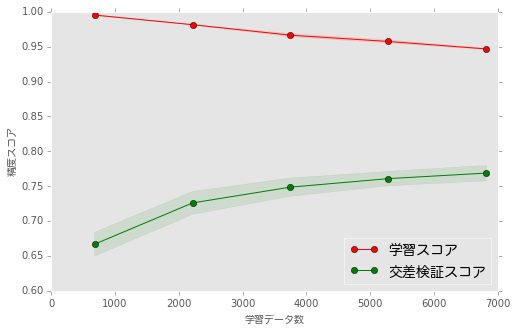

In [52]:
%time plot_learning_curve(pipeline, "accuracy vs. training set size", reviews_train, sentiment_train, cv=5)

### Step 6: How to tune Parameters?

What we've seen so far is only a tip of the iceberg: there are many other parameters to tune. One example is what algorithm to use for training.

We've used Naive Bayes above, but scikit-learn supports many classifiers out of the box: Support Vector Machines, Nearest Neighbours, Decision Trees, Ensamble methods...

[We can ask]: What is the effect of IDF weighting on accuracy? Does the extra processing cost of lemmatization (vs. just plain words) really help?

Let's find out:

In [59]:
params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (tokenizer.Lemma, tokenizer.Stem),
}

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(sentiment_train, n_folds=5),  # what type of cross validation to use
)

In [60]:
%time nb_detector = grid.fit(reviews_train, sentiment_train)
print(nb_detector.grid_scores_)

CPU times: user 7.56 s, sys: 454 ms, total: 8.01 s
Wall time: 1min 16s
[mean: 0.76879, std: 0.01114, params: {'tfidf__use_idf': True, 'bow__analyzer': <function Lemma at 0x1114b97b8>}, mean: 0.76691, std: 0.01365, params: {'tfidf__use_idf': False, 'bow__analyzer': <function Lemma at 0x1114b97b8>}, mean: 0.76879, std: 0.01427, params: {'tfidf__use_idf': True, 'bow__analyzer': <function Stem at 0x1114b9730>}, mean: 0.77055, std: 0.00993, params: {'tfidf__use_idf': False, 'bow__analyzer': <function Stem at 0x1114b9730>}]


In [61]:
nb_detector.best_score_

0.77054754367452227

In [62]:
nb_detector.best_params_

{'bow__analyzer': <function tokenizer.Stem>, 'tfidf__use_idf': False}

In [63]:
nb_detector.best_estimator_

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function Stem at 0x1114b9730>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
       ...        use_idf=False)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [64]:
# A quick sanity check:
%time print(nb_detector.predict_proba(["wonderful"])[0])
%time print(nb_detector.predict(["wonderful"])[0])
%time print(nb_detector.predict_proba(["Hi mom, how are you?"])[0])
%time print(nb_detector.predict_proba(["WINNER! Credit for free!"])[0])

[ 0.30351477  0.69648523]
CPU times: user 2.47 ms, sys: 668 µs, total: 3.14 ms
Wall time: 2.62 ms
1
CPU times: user 1.66 ms, sys: 270 µs, total: 1.93 ms
Wall time: 1.64 ms
[ 0.63089554  0.36910446]
CPU times: user 3.83 ms, sys: 216 µs, total: 4.05 ms
Wall time: 4.21 ms
[ 0.61563257  0.38436743]
CPU times: user 3.47 ms, sys: 58 µs, total: 3.52 ms
Wall time: 3.6 ms


In [65]:
# And overall scores on the test set,
# the one we haven't used at all during training:

predictions = nb_detector.predict(reviews_test)
print(confusion_matrix(sentiment_test, predictions))
print(classification_report(sentiment_test, predictions))

[[784 297]
 [197 855]]
             precision    recall  f1-score   support

          0       0.80      0.73      0.76      1081
          1       0.74      0.81      0.78      1052

avg / total       0.77      0.77      0.77      2133



This is then the realistic predictive performance we can expect from our spam detection pipeline, when using lowercase with lemmatization, TF-IDF and Naive Bayes for classifier.

### SVM

Let's try with another classifier: **Support Vector Machines (SVM)**. SVMs are a great starting point when classifying text data, getting state of the art results very quickly and with pleasantly little tuning (although a bit more than Naive Bayes):

In [ ]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),  # <== change here
])

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(sentiment_train, n_folds=5),  # what type of cross validation to use
)

In [ ]:
%time svm_detector = grid_svm.fit(reviews_train, sentiment_train) # find the best combination from param_svm
print(svm_detector.grid_scores_)

In [ ]:
# Sanity check again:

%time print(svm_detector.predict(["Hi mom, how are you?"])[0])
%time print(svm_detector.predict(["WINNER! Credit for free!"])[0])

In [ ]:
print(confusion_matrix(sentiment_test, svm_detector.predict(reviews_test)))
print(classification_report(sentiment_test, svm_detector.predict(reviews_test)))

This is then the realistic predictive performance we can expect from our sentiment detection pipeline, when using SVMs.

### Step 7: Productionalizing a predictor

With basic analysis and tuning done, the real work (engineering) begins.

The final step for a production predictor would be training it on the entire dataset again, to make full use of all the data available. We'd use the best parameters found via cross validation above, of course. This is very similar to what we did in the beginning, but this time having insight into its behaviour and stability. Evaluation was done honestly, on distinct train/test subset splits.

The final predictor can be serialized to disk, so that the next time we want to use it, we can skip all training and use the trained model directly:

In [66]:
# store the spam detector to disk after training
os.chdir("/Users/Bya/Dropbox/Research/datas/Detecter/")
with open('detecter_sentiment_reviews_nb0204.pkl', 'wb') as fout:
    pickle.dump(nb_detector, fout)

In [ ]:
# store the spam detector to disk after training
with open('svm_reviews_sentiment_detector.pkl', 'wb') as fout:
    pickle.dump(svm_detector, fout)

# store the spam detector to disk after training
with open('nb_reviews_sentiment_detector.pkl', 'wb') as fout:
    pickle.dump(nb_detector, fout)

In [ ]:
with open('svm_reviews_sentiment_detector.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'utf-8'
    svm_detector_reloaded = u.load()
    print(svm_detector_reloaded)

In [ ]:
%time print('before:', svm_detector.predict([review4])[0])
%time print ('after:', svm_detector_reloaded.predict([review4])[0])

In [ ]:
tweet = """
#Flamino!! Haha this is brilliant! Good work for his 1st goal. Cool as ice, walk in the park! #LFC #YNWA
"""

np_score = nb_detector.predict_proba([tweet])[0]
np = nb_detector.predict([tweet])[0]

print(np_score)
print(np)

In [58]:
tweet = """
#Flamino!! Haha this is brilliant! Good work for his 1st goal. Cool as ice, walk in the park! #LFC #YNWA
"""

np_score = nb_detector.predict_proba([tweet])[0]
np = nb_detector.predict([tweet])[0]

print(np_score)
print(np)

NotFittedError: CountVectorizer - Vocabulary wasn't fitted.